In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

# get the region of interest
def sel_extent(ds):
    return ds.sel(lat=slice(6,36),lon=slice(68,98))

In [2]:
dd = {}
dd["pm"] = sel_extent(xr.open_dataset("../data/daily_surface_pm25_RH50.nc"))
dd["emission"] = sel_extent(xr.open_dataset("../data/daily_emission.nc"))
dd["gas"] = sel_extent(xr.open_dataset("../data/daily_gas_column.nc"))
dd["aod"] = sel_extent(xr.open_dataset("../data/daily_aod.nc"))
dd["met"] = sel_extent(xr.open_dataset("../data/daily_meteo.nc"))

mask = xr.open_dataset("../data/land_mask.nc")

In [3]:
# sum over the dust
dd["emission"]["EmisDST_Natural"] = dd["emission"]["EmisDST1_Natural"]\
                                    +dd["emission"]["EmisDST2_Natural"]\
                                    +dd["emission"]["EmisDST3_Natural"]\
                                    +dd["emission"]["EmisDST4_Natural"]

In [4]:
feature_ml = {
    "pm":["PM25"],
    "gas":['CO_trop', 'SO2_trop', 'NO2_trop', 'CH2O_trop', 'NH3_trop'],
    "aod":['AOT_C', 'AOT_DUST_C'],
    "met":['T2M', 'PBLH', 'U10M', 'V10M', 'PRECTOT', 'RH'],
    "emission":['EmisDST_Natural', 
                'EmisNO_Fert', 'EmisNO_Lightning', 'EmisNO_Ship', 'EmisNO_Soil'],
}

feature_ls = [feature_ml[k] for k in feature_ml] #if k!="pm"]
# ref https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
feature_ls = sum(feature_ls,[])

## without mask

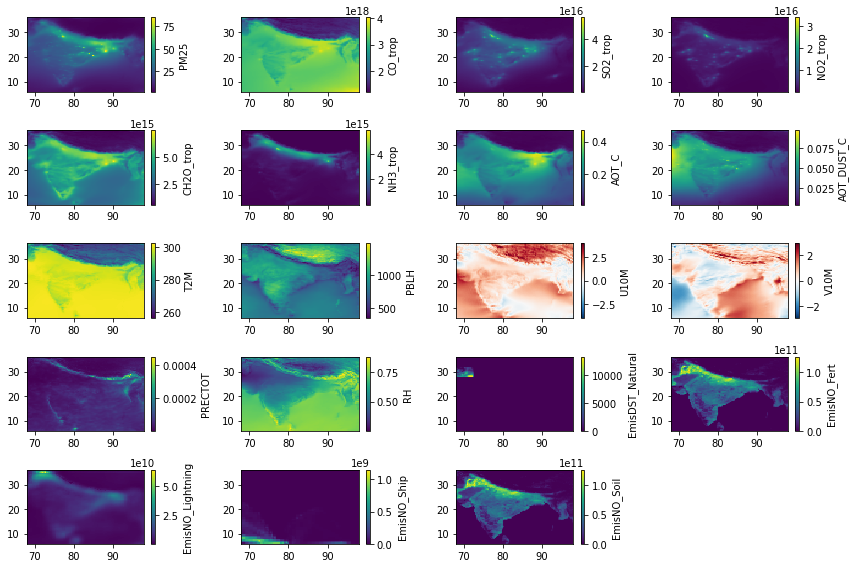

In [5]:
ds = xr.merge(dd[k][feature_ml[k]] for k in dd)#.where(mask["mask"])
fig = plt.figure(figsize=(12,8))
for i in range(len(feature_ls)):
    f = feature_ls[i]
    ax = fig.add_subplot(5,4,i+1)
    ds[f].mean(dim="time").plot(ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

## with mask

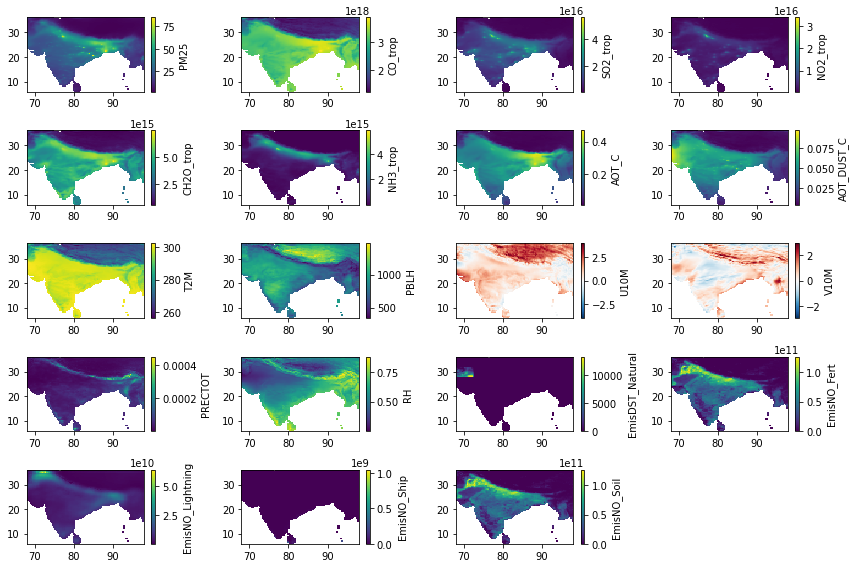

In [6]:
ds = xr.merge(dd[k][feature_ml[k]] for k in dd).where(mask["mask"])
fig = plt.figure(figsize=(12,8))
for i in range(len(feature_ls)):
    f = feature_ls[i]
    ax = fig.add_subplot(5,4,i+1)
    ds[f].mean(dim="time").plot(ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

## save and load

In [7]:
# save
train = ds.sel(time=ds.time.dt.month.isin([1,2,3,5,6,7,9,10,11,12]))\
      .to_dataframe().reset_index().dropna()
train.to_parquet('../data/daily_train.gzip', compression='gzip') 

test = ds.sel(time=ds.time.dt.month.isin([4,8]))\
      .to_dataframe().reset_index().dropna()
test.to_parquet('../data/daily_test.gzip', compression='gzip') 

print("shape of train:", train.shape)
print("shape of test:", test.shape)

# load 
train_l = pd.read_parquet('../data/daily_train.gzip')
test_l = pd.read_parquet('../data/daily_test.gzip')

print("shape of train_l:", train_l.shape)
print("shape of test_l:", test_l.shape)

# test
np.testing.assert_array_equal(train[feature_ls].values, train_l[feature_ls].values)
np.testing.assert_array_equal(test[feature_ls].values, test_l[feature_ls].values)
print("passed the test!")

shape of train: (2174512, 22)
shape of test: (436333, 22)
shape of train_l: (2174512, 22)
shape of test_l: (436333, 22)
passed the test!
